## Intagrative analysis of TF dynamics using sci-mtChIL-seq datasets

To reproduce this notebook, please download following data from [Zenodo repository](https://doi.org/10.5281/zenodo.10925338).

In [1]:
Sys.setenv(LANGUAGE = "en")
options(warn = -1)

library(Seurat)
library(Signac)
library(GenomicAlignments)
library(GenomicFeatures)
library(tidyverse)
source('R/mytools.R')

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, saveRDS, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following 

In [2]:
mgene_coding_use <- readRDS('data/out/mgene_coding_use.rds')
degs <- read_tsv("data/out/cluster_all_degs_from_analysis2.tsv.gz",show_col_types = FALSE)
pre_cg_output <- readRDS("data/out/pre_cg_output_1k.rds")

In [3]:
path <- list.files("data/out/denoised/",full.names = T,pattern = "denoised_avg.csv")
names(path) <- sub('_.*','',basename(path))
denoised <- path %>%
  map(read_csv,show_col_types = F,col_names = F) %>%
  map(~{
    sm <- .x %>%
      filter(!duplicated(X1)) %>% 
      mutate(X1 = gsub("_","-",X1)) %>%
      tib2df() %>% as("sparseMatrix")
    colnames(sm) <- sprintf("ic_%04d",1:1000)
    rownames(sm) <- gsub('_','-',rownames(sm))
    return(sm)
    })
map_dbl(denoised,nrow)

Brg1 H3K27ac H3K4me3    MyoD    Myog  RNAPII 
  34115   30298   10701    2348    2591   44178

In [4]:
mgene_coding_use_deg <- mgene_coding_use %>%
  subset(symbol %in% unique(degs$gene))
mgene_coding_use_deg_ex <- mgene_coding_use_deg %>%
  extend(upstream = 50*10^3)
mgene_tss <- mgene_coding_use_deg %>% flank(width = 1) %>% gr2reg() 
tab_tss <- tibble(symbol = mgene_coding_use_deg$symbol,
                  strand = as.character(strand(mgene_coding_use_deg)),
                  tss = as.double(sub(".*-","",mgene_tss))) %>%
  mutate(strand = ifelse(strand == "+",1,-1))
vars_anno <- denoised %>% 
  map(~{
    gr <- reg2gr(rownames(.x))
    ol <- findOverlaps(mgene_coding_use_deg_ex,gr)
    df <- as_tibble(ol) %>%
      mutate(
        symbol = mgene_coding_use_deg_ex$symbol[queryHits],
        reg = rownames(.x)[subjectHits]
      ) %>%
      select(-queryHits,-subjectHits)
    tmp <- df %>% 
      left_join(tab_tss,by = "symbol") %>%
      mutate(center = as.double(sub(".*-","",reg)) - 2499,
             gap = strand*(center - tss),
             bin = round(gap/5000))
    int <- tmp %>%
      mutate(gap = gap - 5000*bin) %>%
      pull(gap) %>% unique() %>% sort() %>%
      abs() %>% which.max()
    if(int == 2) tmp <- tmp %>% mutate(bin = bin+1)
    tmp$region <- 'Genebody'
    tmp$region[abs(tmp$bin) <=  2] <- 'Flank'
    tmp$region[tmp$bin == 0] <- 'TSS'
    tmp$region[tmp$bin <=  -3] <- 'Upstream'
    tmp %>% arrange(symbol,reg,gap)
    })
vars_anno$H3K4me3 <- vars_anno$H3K4me3 %>% filter(!region %in% c('Genebody','Upstream'))
vars_anno$MyoD <- vars_anno$MyoD %>% filter(region != 'Genebody')
vars_anno$Myog <- vars_anno$Myog %>% filter(region != 'Genebody')
vars_anno$RNAPII <- vars_anno$RNAPII %>% filter(bin>=0)

In [5]:
allvars <- vars_anno %>% 
  bind_rows(.id = 'ab') %>%
  mutate(region = factor(region,c("Genebody","TSS","Flank","Upstream")))
head(allvars)

ab,symbol,reg,strand,tss,center,gap,bin,region
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Brg1,AA474408,chr7-110057500-110062499,-1,110061326,110060000,1326,0,TSS
Brg1,AA474408,chr7-110062500-110067499,-1,110061326,110065000,-3674,-1,Flank
Brg1,AC123072.1,chr1-33902500-33907499,1,33908271,33905000,-3271,-1,Flank
Brg1,AC123072.1,chr1-33907500-33912499,1,33908271,33910000,1729,0,TSS
Brg1,AC123072.1,chr1-33912500-33917499,1,33908271,33915000,6729,1,Flank
Brg1,AC123072.1,chr1-33917500-33922499,1,33908271,33920000,11729,2,Flank


In [6]:
allvars2 <- allvars %>%
  split(.$symbol) %>% map(~with(.x,split(reg,ab))) %>% 
  li2df() %>% rename(symbol = 1,regs = 2) 
usetarregs <- with(allvars2,structure(regs,names = symbol))

usegenes <- c("Mef2a","Lmod3","Xirp1","Ptn")
locals <- list()
for(ab in  names(vars_anno)){
  for(sym in usegenes){
    regs <- usetarregs[[sym]][[ab]]
    regs <- intersect(regs,rownames(denoised[[ab]]))
    if(length(regs)<=1) regs <- NULL
    if(is.null(regs)){
      res <- NA
    }else{
      res <- denoised[[ab]][regs,]
      if(is.vector(res)) {
        res <- t(as.matrix(res))
        rownames(res) <- regs
      }
      rownames(res) <- sprintf("%s:%s",ab,rownames(res))
      colnames(res) <- NULL
      }
    locals[[sym]][[ab]] <- res
  }
}
locals <- map(locals,~do.call(rbind,.x[!is.na(.x)]))
locals <- locals[!map_lgl(locals,is.null)]
summary(map_lgl(locals,is.null))

   Mode   FALSE 
logical       4 

In [8]:
Sys.setenv(RETICULATE_PYTHON = "~/.conda/envs/gene_trajectory/bin/python")
reticulate::use_condaenv('~/.conda/envs/gene_trajectory')
library(GeneTrajectory)
source("R/GeneTrajectory_mod.R")
cal_ot_mat_from_numpy <- reticulate::import('gene_trajectory.compute_gene_distance_cmd')$cal_ot_mat_from_numpy
dists <- locals %>%
  map(~{
    tmp <- as.matrix(.x)
    tmp[is.na(tmp)] <- min(tmp,na.rm = TRUE)
    d <- cal_ot_mat_from_numpy(
      ot_cost = pre_cg_output[["graph.dist"]], 
      gene_expr = t(tmp), num_iter_max = 50000, 
      show_progress_bar = FALSE
    )
    rownames(d) <- rownames(tmp)
    colnames(d) <- rownames(tmp)
    return(d)
  },.progress = TRUE,.options = furrr_options(seed = T))

 ■■■■■■■■■                         25% |  ETA:  2m

 ■■■■■■■■■■■■■■■■                  50% |  ETA: 49s

 ■■■■■■■■■■■■■■■■■■■■■■■           75% |  ETA: 17s



In [9]:
pcurve_fitting <- function(data,usecomp = 1:2){
  curve <- f_predcuv(data,usecomp = usecomp)
  sqrt_sum <- curve[['cuv1']]$dist
  data <- f_lambdaext(data,curve)
  densities <- f_preddens(data)
  list(
    data = data,curve = curve,sqrt_sum = sqrt_sum,
    densities = densities
    )
}

dists2pcurves <- function(dists,pcurve_usecomp = 1:2){
  diffusionmaps <- names(dists) %>%
    structure(names = names(dists)) %>%
    map(~{
      mat <- dists[[.x]] 
      name <- sub("\\..$","",rownames(mat))
      idx1 <- !duplicated(name)
      tmp <- mat[idx1,idx1]
      
      K <- min(nrow(tmp),5)
      sig <- median(apply(tmp,1,function(x) sort(x)[K]))
    
      if(nrow(tmp)>=5) {
        res <- GetGeneEmbedding_(tmp,nEV = 10,sigma = NULL,t = 1,K = 10)
      }else{
        res <- NA
      }
      return(res)
    }) %>%
    map(~{
      if(all(is.na(.x))) return(NA)
      .x$diffu.emb %>%
        as_tibble(rownames = 'feat') %>%
        separate(feat,into = c('ab','seq','st','en')) %>%
        unite(reg,seq,st,en,sep = '-')
      }) 
  dat <- diffusionmaps[!is.na(diffusionmaps)] %>%
    bind_rows(.id = 'symbol') %>%
    inner_join(allvars,by = c("symbol","reg","ab")) %>%
    distinct() %>% nest(.by = symbol) %>%
    mutate(
      test = map_lgl(data,~all(
        sum(.x$ab == 'RNAPII') >= 3,
        length(unique(.x$ab)) >= 3
        ))
      ) %>%
    filter(test) %>% select(-test) %>%
    mutate(
      data = map(data,pcurve_fitting,usecomp = pcurve_usecomp,.progress = TRUE),
      data = map(data,li2df)
      ) %>% 
    unnest(data) %>% spread(name,data) %>%
    select(symbol,data,curve,sqrt_sum,densities
    ) %>%
    unnest(sqrt_sum)
    return(dat)
}

In [10]:
dat_mks <- dists2pcurves(dists,pcurve_usecomp = 1:2)
print(dat_mks)

# A tibble: 4 × 5
  symbol data                curve             sqrt_sum densities         
  <chr>  <list>              <list>               <dbl> <list>            
1 Lmod3  <tibble [29 × 19]>  <named list [2]> 0.0000126 <tibble [100 × 8]>
2 Mef2a  <tibble [116 × 19]> <named list [2]> 0.0000260 <tibble [100 × 8]>
3 Ptn    <tibble [71 × 19]>  <named list [2]> 0.0000641 <tibble [100 × 6]>
4 Xirp1  <tibble [27 × 19]>  <named list [2]> 0.0000378 <tibble [100 × 8]>


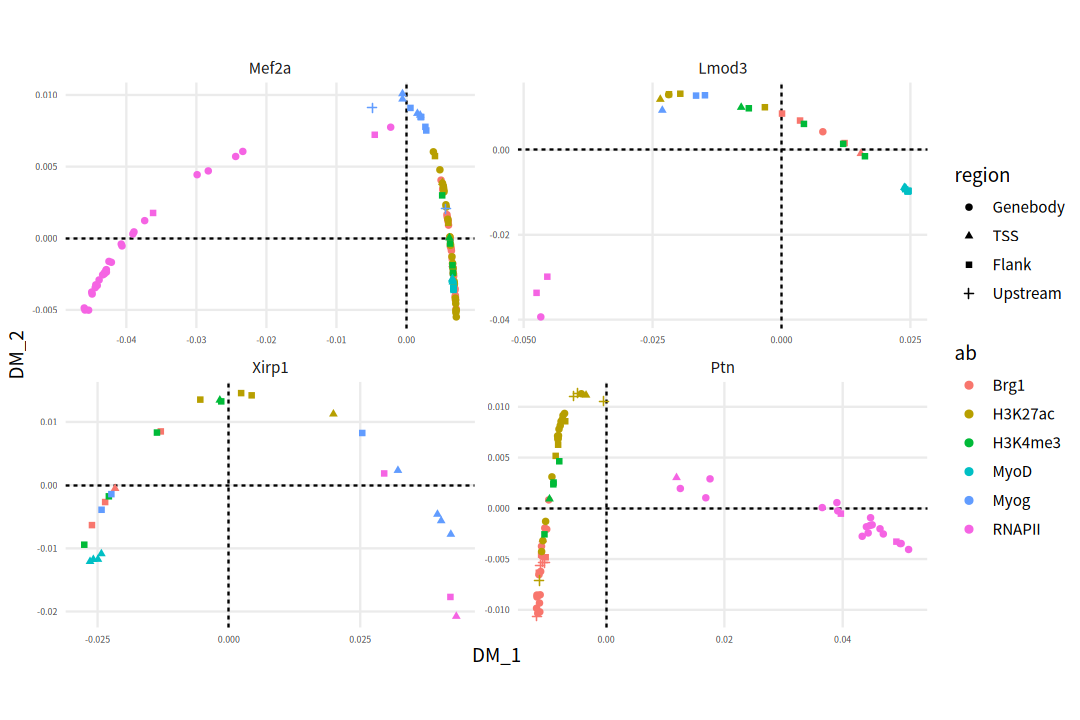

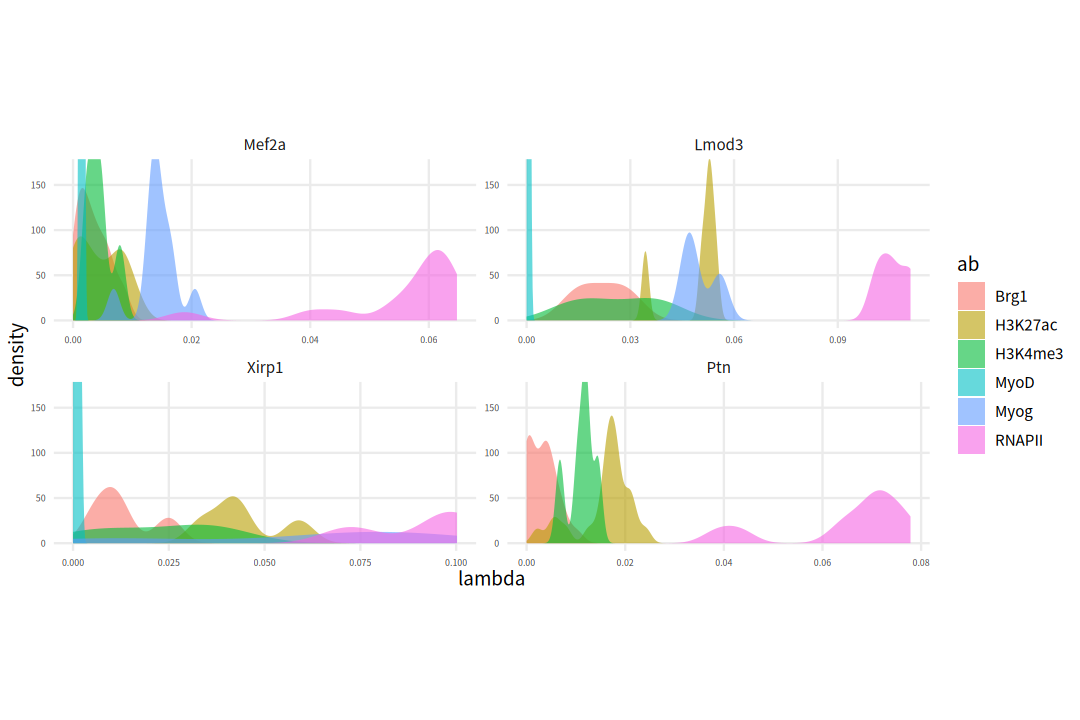

In [11]:
options(repr.plot.width = 9,repr.plot.height = 6)
gt_plot(dat_mks,usegenes,nrow = 2)
lambda_dens(dat_mks,usegenes,ymax = 170,nrow = 2)

In [12]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /usr/local/packages/mambaforge/lib/libmkl_gf_lp64.so.2;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Tokyo
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] GeneTrajectory_1.0.0        lubridate_1.9.3            
 [3] forcats_1.0.0               stringr_1.5.1              
 [5] dplyr_1.1.4                 purrr_1.0.4                
 [7] readr_2.1.5                 tidyr_1.3.1       